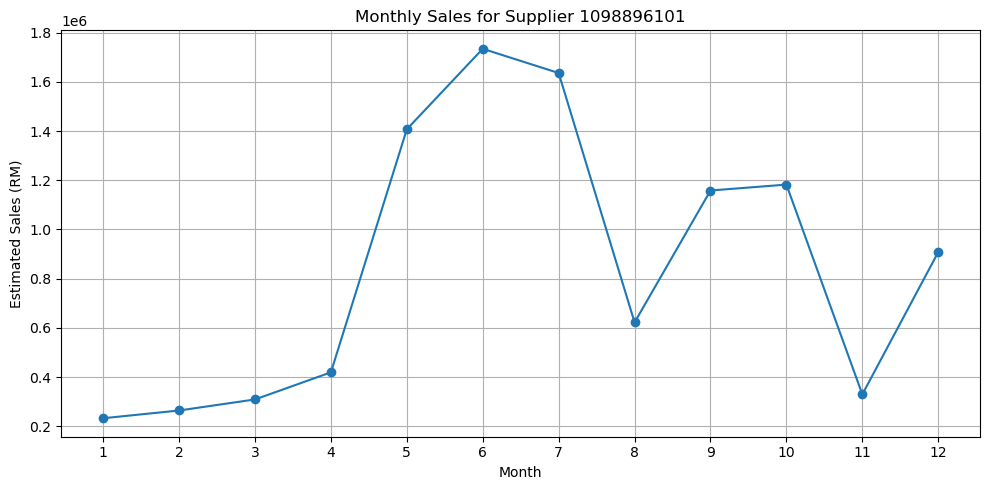

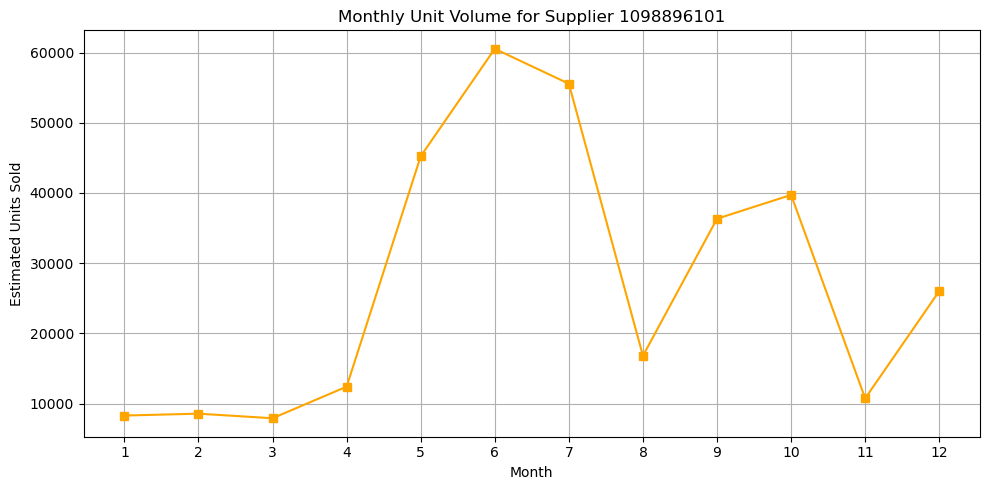

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load CSVs
sales = pd.read_csv('./CSVs/Monthly_sales_forecast.csv')
products = pd.read_csv('./CSVs/product_table.csv')

# Step 2: Merge sales with product info to get SupplierKey
merged = pd.merge(sales, products, on='ProductKey')

# Step 3: Filter for Supplier 1098896101
supplier_df = merged[merged['SupplierKey'] == 1098896101]

# Step 4: Group by month and sum estimated sales
monthly_sales = supplier_df.groupby('TransactionMonth')['EstimatedSales'].sum().reset_index()

# Step 5a: Plot the estimated sales per month
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales['TransactionMonth'], monthly_sales['EstimatedSales'], marker='o')
plt.title('Monthly Sales for Supplier 1098896101')
plt.xlabel('Month')
plt.ylabel('Estimated Sales (RM)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5b: Group by month and sum unit volume
monthly_volume = supplier_df.groupby('TransactionMonth')['EstimatedUnitVolume'].sum().reset_index()

# Plot unit volume per month
plt.figure(figsize=(10, 5))
plt.plot(monthly_volume['TransactionMonth'], monthly_volume['EstimatedUnitVolume'], marker='s', color='orange')
plt.title('Monthly Unit Volume for Supplier 1098896101')
plt.xlabel('Month')
plt.ylabel('Estimated Units Sold')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd

# Load all CSVs
sales = pd.read_csv('./CSVs/Monthly_sales_forecast.csv')
products = pd.read_csv('./CSVs/product_table.csv')
suppliers = pd.read_csv('./CSVs/supplier_table.csv')
brands = pd.read_csv('./CSVs/brand_table.csv')
categories = pd.read_csv('./CSVs/product_category_table.csv')

# Merge sales + product
merged = pd.merge(sales, products, on='ProductKey', how='left')

# Merge with supplier emissions (Est_Emission_Int_x)
merged = pd.merge(merged, suppliers[['SupplierKey', 'Est_Emission_Int']], on='SupplierKey', how='left')

# Merge with brand emissions (Est_Emission_Int_y)
merged = pd.merge(merged, brands[['BrandKey', 'Est_Emission_Int']], on='BrandKey', how='left')

# Merge with category emissions
merged = pd.merge(
    merged,
    categories[['ProductCategory_Lvl1', 'ProductCategory_Lvl2', 'Est_Emission_Int']],
    on=['ProductCategory_Lvl1', 'ProductCategory_Lvl2'],
    how='left'
)

# Rename emission columns for clarity
merged = merged.rename(columns={
    'Est_Emission_Int_x': 'Supplier_Emissions',
    'Est_Emission_Int_y': 'Brand_Emissions',
    'Est_Emission_Int': 'Category_Emissions'
})

# Total Emissions per unit
merged['Total_Emissions_per_Unit'] = (
    merged['Supplier_Emissions'].fillna(0) +
    merged['Brand_Emissions'].fillna(0) +
    merged['Category_Emissions'].fillna(0)
)

# Total Emissions per row (unit volume x per unit emissions)
merged['Total_Emissions'] = merged['EstimatedUnitVolume'] * merged['Total_Emissions_per_Unit']

# Final merged dataframe is ready
merged_all = merged.copy()

# Convert margin from '34%' string to float 0.34
merged_all['Margin'] = merged_all['Margin'].str.rstrip('%').astype(float) / 100

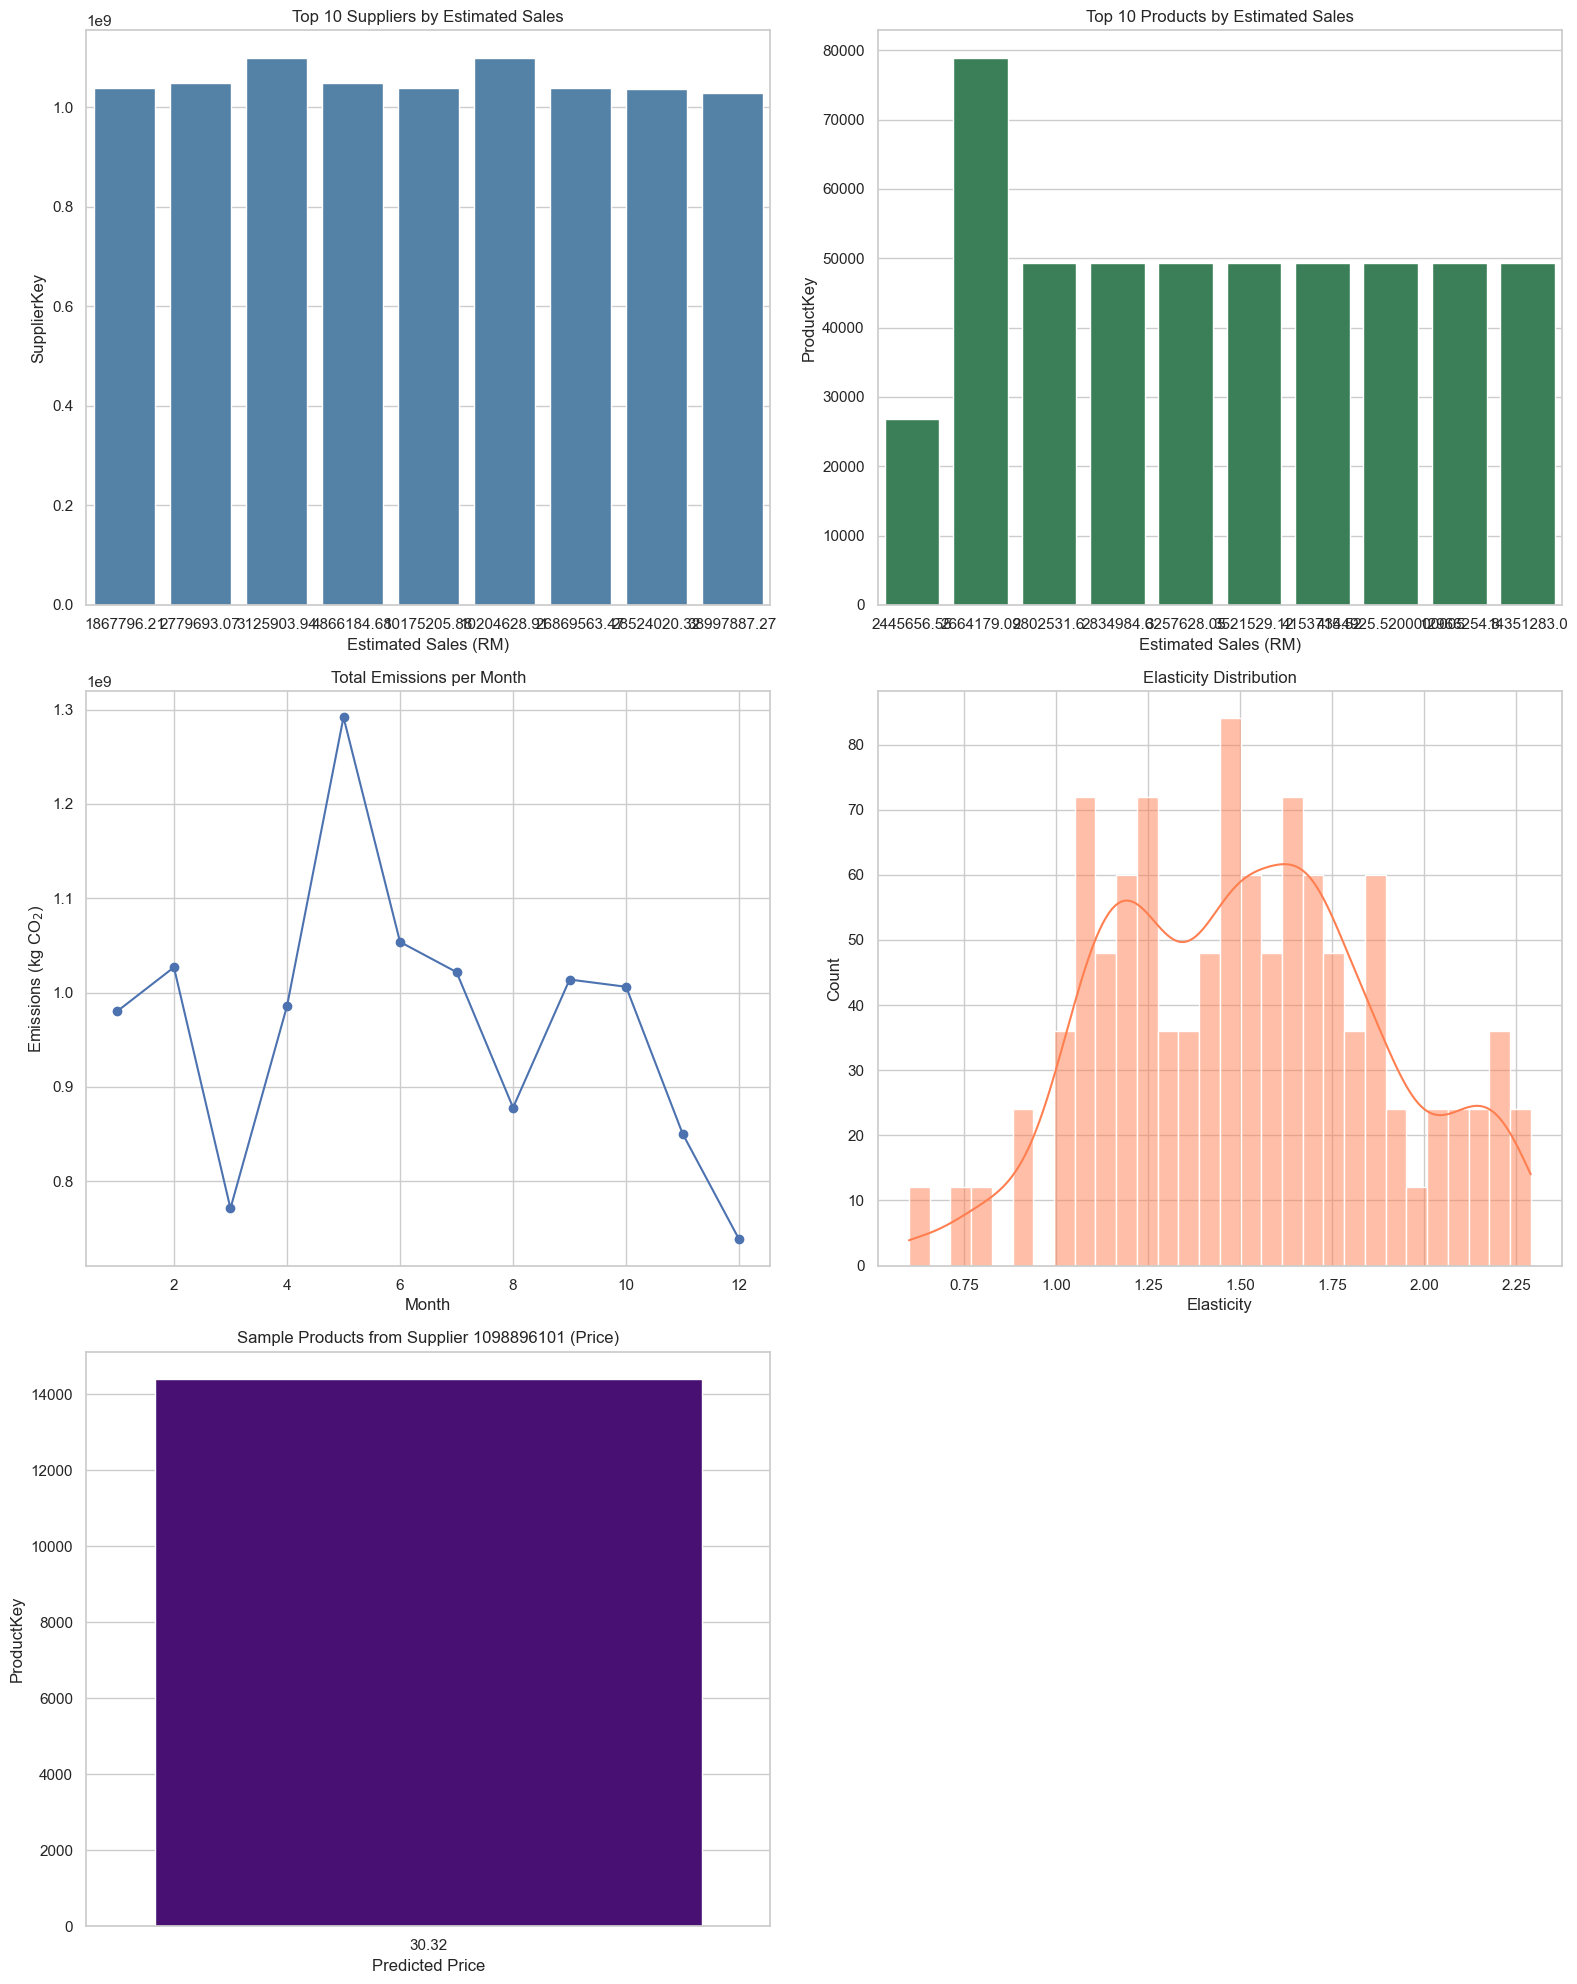

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(16, 20))

# ---------- 1. Supplier Summary ----------
supplier_summary = merged_all.groupby('SupplierKey').agg({
    'EstimatedSales': 'sum',
    'EstimatedUnitVolume': 'sum',
    'Total_Emissions': 'sum'
}).reset_index().sort_values('EstimatedSales', ascending=False).head(10)

plt.subplot(3, 2, 1)
sns.barplot(data=supplier_summary, x='EstimatedSales', y='SupplierKey', color='steelblue')
plt.title('Top 10 Suppliers by Estimated Sales')
plt.xlabel('Estimated Sales (RM)')
plt.ylabel('SupplierKey')

# ---------- 2. Top Products by Sales ----------
top_products = merged_all.groupby('ProductKey').agg({
    'EstimatedSales': 'sum',
    'EstimatedUnitVolume': 'sum',
    'PredictedPrice': 'mean',
    'Elasticity': 'mean',
    'Margin': 'mean',
    'Total_Emissions_per_Unit': 'mean'
}).sort_values('EstimatedSales', ascending=False).head(10).reset_index()

plt.subplot(3, 2, 2)
sns.barplot(data=top_products, x='EstimatedSales', y='ProductKey', color='seagreen')
plt.title('Top 10 Products by Estimated Sales')
plt.xlabel('Estimated Sales (RM)')
plt.ylabel('ProductKey')

# ---------- 3. Emissions by Month ----------
monthly_emissions = merged_all.groupby('TransactionMonth').agg({
    'EstimatedSales': 'sum',
    'EstimatedUnitVolume': 'sum',
    'Total_Emissions': 'sum'
}).reset_index()

plt.subplot(3, 2, 3)
plt.plot(monthly_emissions['TransactionMonth'], monthly_emissions['Total_Emissions'], marker='o')
plt.title('Total Emissions per Month')
plt.xlabel('Month')
plt.ylabel('Emissions (kg CO$_2$)')

# ---------- 4. Elasticity Distribution ----------
plt.subplot(3, 2, 4)
sns.histplot(merged_all['Elasticity'], bins=30, kde=True, color='coral')
plt.title('Elasticity Distribution')
plt.xlabel('Elasticity')

# ---------- 5. Sample Supplier Products ----------
supplier_products = merged_all[merged_all['SupplierKey'] == 1098896101]
sample = supplier_products.head(10)

plt.subplot(3, 2, 5)
sns.barplot(data=sample, x='PredictedPrice', y='ProductKey', color='indigo')
plt.title('Sample Products from Supplier 1098896101 (Price)')
plt.xlabel('Predicted Price')
plt.ylabel('ProductKey')

plt.tight_layout()
plt.show()


In [41]:
# Filter only products from the target supplier
supplier_support_df = merged_all[merged_all['SupplierKey'] == 1098896101].copy()

# Optional preview
print(f"Number of rows: {len(supplier_support_df)}")
supplier_support_df[['ProductKey', 'PredictedPrice', 'EstimatedUnitVolume', 'EstimatedSales']].head()

Number of rows: 120


,ProductKey,PredictedPrice,EstimatedUnitVolume,EstimatedSales
0,14397,30.32,371,11248.72
1,14397,30.32,1014,30744.48
2,14397,30.32,1711,51877.52
3,14397,30.32,6409,194320.88
4,14397,30.32,5475,166002.00


In [45]:
# Step 4: Apply 15% discount
supplier_support_df['NewPrice'] = supplier_support_df['PredictedPrice'] * 0.85

# Calculate % change in price (used for elasticity in Step 5)
supplier_support_df['PctPriceChange'] = (supplier_support_df['NewPrice'] - supplier_support_df['PredictedPrice']) / supplier_support_df['PredictedPrice']


# Show all rows in the DataFrame preview
pd.set_option('display.max_rows', None)

# Now preview full table with key columns
supplier_support_df[['ProductKey', 'PredictedPrice', 'NewPrice', 'PctPriceChange']]



,ProductKey,PredictedPrice,NewPrice,PctPriceChange
0,14397,30.32,25.7720,-0.15
1,14397,30.32,25.7720,-0.15
2,14397,30.32,25.7720,-0.15
3,14397,30.32,25.7720,-0.15
4,14397,30.32,25.7720,-0.15
5,14397,30.32,25.7720,-0.15
6,14397,30.32,25.7720,-0.15
7,14397,30.32,25.7720,-0.15
8,14397,30.32,25.7720,-0.15
9,14397,30.32,25.7720,-0.15


In [47]:
# Step 5a: Calculate % volume change using elasticity
supplier_support_df['PctVolumeChange'] = -supplier_support_df['Elasticity'] * supplier_support_df['PctPriceChange']

# Step 5b: Calculate new volume
supplier_support_df['NewVolume'] = supplier_support_df['EstimatedUnitVolume'] * (1 + supplier_support_df['PctVolumeChange'])

# Optional: round new volume for realism
supplier_support_df['NewVolume'] = supplier_support_df['NewVolume'].round()

# Preview all products with price, volume change, and new volume
supplier_support_df[['ProductKey', 'PredictedPrice', 'NewPrice', 'Elasticity', 'EstimatedUnitVolume', 'NewVolume', 'PctVolumeChange']]


,ProductKey,PredictedPrice,NewPrice,Elasticity,EstimatedUnitVolume,NewVolume,PctVolumeChange
0,14397,30.32,25.7720,1.51,371,455.0,0.2265
1,14397,30.32,25.7720,1.51,1014,1244.0,0.2265
2,14397,30.32,25.7720,1.51,1711,2099.0,0.2265
3,14397,30.32,25.7720,1.51,6409,7861.0,0.2265
4,14397,30.32,25.7720,1.51,5475,6715.0,0.2265
5,14397,30.32,25.7720,1.51,1335,1637.0,0.2265
6,14397,30.32,25.7720,1.51,778,954.0,0.2265
7,14397,30.32,25.7720,1.51,1105,1355.0,0.2265
8,14397,30.32,25.7720,1.51,2146,2632.0,0.2265
9,14397,30.32,25.7720,1.51,1103,1353.0,0.2265


In [49]:
# Step 6a: Recalculate original and new sales
supplier_support_df['OrigSales'] = supplier_support_df['EstimatedUnitVolume'] * supplier_support_df['PredictedPrice']
supplier_support_df['NewSales'] = supplier_support_df['NewVolume'] * supplier_support_df['NewPrice']

# Step 6b: Sales uplift
supplier_support_df['SalesUplift'] = supplier_support_df['NewSales'] - supplier_support_df['OrigSales']

# Optional: format with RM commas
supplier_support_df['OrigSales'] = supplier_support_df['OrigSales'].round(2)
supplier_support_df['NewSales'] = supplier_support_df['NewSales'].round(2)
supplier_support_df['SalesUplift'] = supplier_support_df['SalesUplift'].round(2)

# Preview key columns
supplier_support_df[['ProductKey', 'OrigSales', 'NewSales', 'SalesUplift']]


,ProductKey,OrigSales,NewSales,SalesUplift
0,14397,11248.72,11726.26,477.54
1,14397,30744.48,32060.37,1315.89
2,14397,51877.52,54095.43,2217.91
3,14397,194320.88,202593.69,8272.81
4,14397,166002.00,173058.98,7056.98
5,14397,40477.20,42188.76,1711.56
6,14397,23588.96,24586.49,997.53
7,14397,33503.60,34921.06,1417.46
8,14397,65066.72,67831.90,2765.18
9,14397,33442.96,34869.52,1426.56


In [53]:
# Step 7a: Calculate new and original profit
supplier_support_df['OrigProfit'] = supplier_support_df['OrigSales'] * supplier_support_df['Margin']
supplier_support_df['NewProfit'] = supplier_support_df['NewSales'] * supplier_support_df['Margin']

# Step 7b: Profit uplift
supplier_support_df['ProfitUplift'] = supplier_support_df['NewProfit'] - supplier_support_df['OrigProfit']

# Round for clean viewing
supplier_support_df[['OrigProfit', 'NewProfit', 'ProfitUplift']] = supplier_support_df[['OrigProfit', 'NewProfit', 'ProfitUplift']].round(2)

# Preview profit impact
supplier_support_df[['ProductKey', 'OrigProfit', 'NewProfit', 'ProfitUplift']]


,ProductKey,OrigProfit,NewProfit,ProfitUplift
0,14397,3824.56,3986.93,162.36
1,14397,10453.12,10900.53,447.40
2,14397,17638.36,18392.45,754.09
3,14397,66069.10,68881.85,2812.76
4,14397,56440.68,58840.05,2399.37
5,14397,13762.25,14344.18,581.93
6,14397,8020.25,8359.41,339.16
7,14397,11391.22,11873.16,481.94
8,14397,22122.68,23062.85,940.16
9,14397,11370.61,11855.64,485.03


In [57]:
# Step 8a: Emissions before and after
supplier_support_df['OrigEmissions'] = supplier_support_df['EstimatedUnitVolume'] * supplier_support_df['Total_Emissions_per_Unit']
supplier_support_df['NewEmissions'] = supplier_support_df['NewVolume'] * supplier_support_df['Total_Emissions_per_Unit']

# Step 8b: Offset cost (RM 0.25 per kg CO₂)
supplier_support_df['OrigOffsetCost'] = supplier_support_df['OrigEmissions'] * 0.25
supplier_support_df['NewOffsetCost'] = supplier_support_df['NewEmissions'] * 0.25
supplier_support_df['OffsetCostChange'] = supplier_support_df['NewOffsetCost'] - supplier_support_df['OrigOffsetCost']

# Round values
cols = ['OrigEmissions', 'NewEmissions', 'OrigOffsetCost', 'NewOffsetCost', 'OffsetCostChange']
supplier_support_df[cols] = supplier_support_df[cols].round(2)

# Preview
supplier_support_df[['ProductKey', 'OrigEmissions', 'NewEmissions', 'OrigOffsetCost', 'NewOffsetCost', 'OffsetCostChange']]


,ProductKey,OrigEmissions,NewEmissions,OrigOffsetCost,NewOffsetCost,OffsetCostChange
0,14397,5467.56,6705.49,1366.89,1676.37,309.48
1,14397,14943.67,18333.26,3735.92,4583.32,847.40
2,14397,25215.61,30933.70,6303.90,7733.42,1429.52
3,14397,94451.68,115850.31,23612.92,28962.58,5349.66
4,14397,80686.99,98961.31,20171.75,24740.33,4568.58
5,14397,19674.36,24125.04,4918.59,6031.26,1112.67
6,14397,11465.66,14059.43,2866.41,3514.86,648.44
7,14397,16284.77,19969.11,4071.19,4992.28,921.08
8,14397,31626.35,38788.71,7906.59,9697.18,1790.59
9,14397,16255.30,19939.63,4063.82,4984.91,921.08


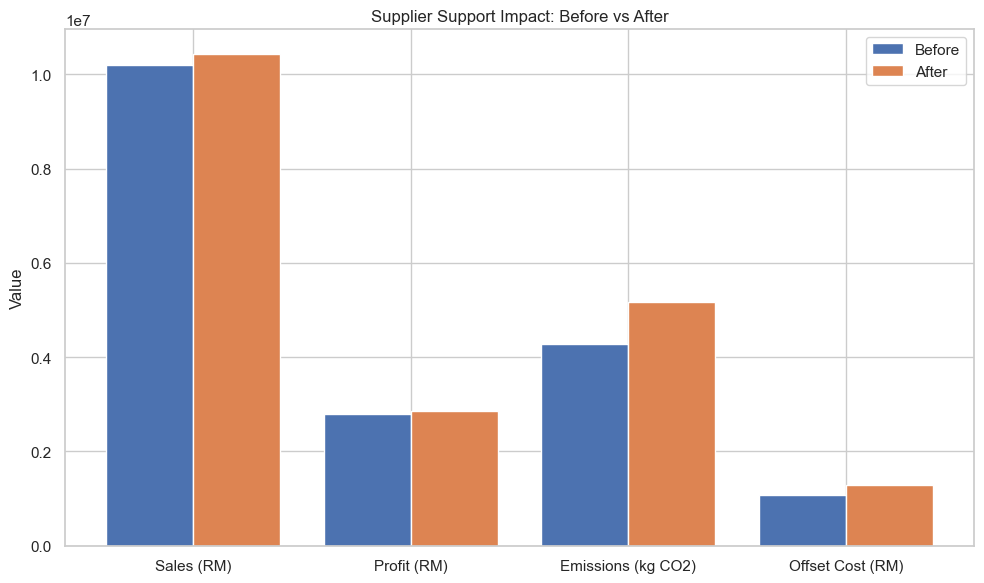

=== 📊 Final Summary with Supplier Bonus ===
Bonus Triggered? ✅ Yes

Previous Profit:      RM 2,794,721.57
Total Profit (w/bonus): RM 2,913,637.71 (+4.26%)

Previous Revenue:     RM 10,204,628.91
Total Revenue:        RM 10,428,081.67 (+2.19%)

Emissions Before:     4,274,166.44 kg CO₂
Emissions After:      5,163,457.08 kg CO₂ (+20.81%)

Emissions per RM Profit (before): 1.5294 kg CO₂/RM
Emissions per RM Profit (after):  1.7722 kg CO₂/RM


In [67]:
import matplotlib.pyplot as plt

# Simplified version of your KPI DataFrame for plotting
plot_data = {
    'Sales (RM)': [
        kpi_df.loc['Original Sales (RM)', 'Value'],
        kpi_df.loc['New Sales (RM)', 'Value']
    ],
    'Profit (RM)': [
        kpi_df.loc['Original Profit (RM)', 'Value'],
        kpi_df.loc['New Profit (RM)', 'Value']
    ],
    'Emissions (kg CO2)': [
        kpi_df.loc['Original Emissions (kg CO2)', 'Value'],
        kpi_df.loc['New Emissions (kg CO2)', 'Value']
    ],
    'Offset Cost (RM)': [
        kpi_df.loc['Original Offset Cost (RM)', 'Value'],
        kpi_df.loc['New Offset Cost (RM)', 'Value']
    ]
}

# Plot setup
categories = list(plot_data.keys())
before = [v[0] for v in plot_data.values()]
after = [v[1] for v in plot_data.values()]
x = range(len(categories))

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(x, before, width=0.4, label='Before', align='center')
plt.bar([i + 0.4 for i in x], after, width=0.4, label='After', align='center')
plt.xticks([i + 0.2 for i in x], categories)
plt.ylabel('Value')
plt.title('Supplier Support Impact: Before vs After')
plt.legend()
plt.tight_layout()
plt.show()


#

# Retrieve values
profit_before = kpi_df.loc['Original Profit (RM)', 'Value']
profit_after = kpi_df.loc['New Profit (RM)', 'Value']
revenue_before = kpi_df.loc['Original Sales (RM)', 'Value']
revenue_after = kpi_df.loc['New Sales (RM)', 'Value']
emissions_before = kpi_df.loc['Original Emissions (kg CO2)', 'Value']
emissions_after = kpi_df.loc['New Emissions (kg CO2)', 'Value']

# Apply bonus if applicable
bonus_triggered = revenue_after > 2_000_000
bonus_amount = 50_000 if bonus_triggered else 0
total_profit_with_bonus = profit_after + bonus_amount

# % Increases
profit_pct_increase = ((total_profit_with_bonus - profit_before) / profit_before) * 100
revenue_pct_increase = ((revenue_after - revenue_before) / revenue_before) * 100
emissions_pct_increase = ((emissions_after - emissions_before) / emissions_before) * 100

# Emissions per RM profit
emissions_per_rm_before = emissions_before / profit_before
emissions_per_rm_after = emissions_after / total_profit_with_bonus

# Output
print("=== 📊 Final Summary with Supplier Bonus ===")
print(f"Bonus Triggered? {'✅ Yes' if bonus_triggered else '❌ No'}\n")

print(f"Previous Profit:      RM {profit_before:,.2f}")
print(f"Total Profit (w/bonus): RM {total_profit_with_bonus:,.2f} (+{profit_pct_increase:.2f}%)\n")

print(f"Previous Revenue:     RM {revenue_before:,.2f}")
print(f"Total Revenue:        RM {revenue_after:,.2f} (+{revenue_pct_increase:.2f}%)\n")

print(f"Emissions Before:     {emissions_before:,.2f} kg CO₂")
print(f"Emissions After:      {emissions_after:,.2f} kg CO₂ (+{emissions_pct_increase:.2f}%)\n")

print(f"Emissions per RM Profit (before): {emissions_per_rm_before:.4f} kg CO₂/RM")
print(f"Emissions per RM Profit (after):  {emissions_per_rm_after:.4f} kg CO₂/RM")
